# Time series analysis and forecasting
 **version 17-12-2020** 

 **Goal:** 

- Explore the data, handle missing values.
- Analysis per store type or per given department for a store type, correlational analysis of activity.
- Perform extensive a time serie analysis (seasonal decomposition, trends, autocorrelation). 
- Model the effects of holidays.
- Predict next weeks of sales using Prophet (Facebook methodology).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

# loading packages
# basic + dates 
import numpy as np
import pandas as pd
from pandas import datetime

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns # advanced vizs

# cloud of words
from wordcloud import WordCloud, STOPWORDS 

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# prophet by Facebook
from fbprophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#from google.colab import files
#uploaded = files.upload()

In [ ]:
# importing train data to learn
features = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet retail/Features data set.csv',
                       parse_dates = True, low_memory = False, index_col = 'Date')
# importing train data to learn
sales = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet retail/sales data-set.csv',
                    parse_dates = True, low_memory = False, index_col = 'Date')
# additional store data
stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet retail/stores data-set.csv',
                     low_memory = False)

# time series as indexes
sales.index

DatetimeIndex(['2010-05-02', '2010-12-02', '2010-02-19', '2010-02-26',
               '2010-05-03', '2010-12-03', '2010-03-19', '2010-03-26',
               '2010-02-04', '2010-09-04',
               ...
               '2012-08-24', '2012-08-31', '2012-07-09', '2012-09-14',
               '2012-09-21', '2012-09-28', '2012-05-10', '2012-12-10',
               '2012-10-19', '2012-10-26'],
              dtype='datetime64[ns]', name='Date', length=421570, freq=None)

In [ ]:
sales.head()

,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-05-02,1,1,24924.50,False
2010-12-02,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-05-03,1,1,21827.90,False


## Exploratory Data Analysis 

In this first section we go through the sales, features and store data, handle missing values.

In [ ]:
# first glance at the sales set: head
print("In total: ", sales.shape)
sales.head(5)

In total:  (421570, 4)


,Store,Dept,Weekly_Sales,IsHoliday
Date,,,,
2010-05-02,1,1,24924.50,False
2010-12-02,1,1,46039.49,True
2010-02-19,1,1,41595.55,False
2010-02-26,1,1,19403.54,False
2010-05-03,1,1,21827.90,False


##### Short description

Historical sales data, which covers to 2010-02-05 to 2012-11-01. Within this tab you will find the following fields:
-	Store - the store number
-	Dept - the department number
-	Date - the week
-	Weekly_Sales -  sales for the given department in the given store
-	IsHoliday - whether the week is a special holiday week


We are dealing with time series data on weekly basis, so it will serve us to convert dates in week number.

In [ ]:
# data extraction
sales['WeekOfYear'] = sales.index.weekofyear
sales['Year'] = sales.index.year
sales['Month'] = sales.index.month

In [ ]:
# first glance at the stores set: head
print("In total: ", stores.shape)
stores.head(5)

In total:  (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


Short description

Anonymized information about the 45 stores, indicating the type and size of store

In [ ]:
# first glance at the features set: head and tail
print("In total: ", features.shape)
features.head(5)

In total:  (8190, 11)


,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-05-02,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-12-02,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-05-03,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


##### Short description

Contains additional data related to the store, department, and regional activity for the given dates.
-	Store - the store number
-	Date - the week
-	Temperature - average temperature in the region
-	Fuel_Price - cost of fuel in the region
-	MarkDown1-5 - anonymized data related to promotional markdowns. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA
-	CPI - the consumer price index
-	Unemployment - the unemployment rate
-	IsHoliday - whether the week is a special holiday week

### Missing values 

In [ ]:
# missing values?
features.isnull().sum()

Store              0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64

We have few variables with missing values that we need to deal with. Let's start with the `MarkDown1/2/3/4/5'.

In [ ]:
# missing values in MarkDown1 or MarkDown2 or MarkDown3 or MarkDown4 or MarkDown5
features[pd.isnull(features.MarkDown1) | pd.isnull(features.MarkDown2) | pd.isnull(features.MarkDown3) | pd.isnull(features.MarkDown4) | pd.isnull(features.MarkDown5)]

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
Date,,,,,,,,,,,
2010-05-02,1,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2010-12-02,1,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2010-02-19,1,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
2010-02-26,1,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
2010-05-03,1,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-21,45,43.54,3.577,4187.83,NaN,238.00,92.68,2977.33,192.458906,8.667,False
2013-03-15,45,42.81,3.834,9867.03,NaN,11.08,912.87,1360.36,193.296277,8.625,False
2013-03-22,45,36.55,3.800,11923.74,NaN,308.00,1764.47,1647.31,193.369533,8.625,False


No, if there's no promotional markdown then there is no `MarkDown1/2/3/4/5'. We can replace these values by zeros.

In [ ]:
# replace NA's by 
Markdowns = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
[features[_markdown].fillna(0, inplace = True) for _markdown in Markdowns]

#features.MarkDown1.fillna(0, inplace = True)
#features.MarkDown2.fillna(0, inplace = True)
#features.MarkDown3.fillna(0, inplace = True)
#features.MarkDown4.fillna(0, inplace = True)
#features.MarkDown5.fillna(0, inplace = True)

[None, None, None, None, None]

The quantity of missing 'CPI' data is equal to quantity of missing 'Unemployment' data. Do they correspond to the same records? 

In [ ]:
# no CPI = no unemployment data ?
empty_CPI = features[pd.isnull(features.CPI)]
empty_CPI[empty_CPI.Unemployment != 0].shape

(585, 11)

Not the same records. Apparently this information is simply missing from the data. No particular pattern observed. In this case, it makes a complete sense to replace NaN with the median values.

In [ ]:
# fill NaN with a median value (skewed distribution)
features['CPI'].fillna(features['CPI'].median(), inplace = True)
features['Unemployment'].fillna(features['Unemployment'].median(), inplace = True)

In [ ]:
# what is the unit of temperature. °C or°F?
features.Temperature.max()

101.95

In [ ]:
#conversion of temperature into °C
features['Temperature'] = features['Temperature'].apply(lambda X : np.round((X-32)*5/9, 1))

In [ ]:
print("Joining features set with additional store information.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
features_store = features.reset_index().merge(stores, how='inner', on='Store').set_index('Date')
print("In total: ", features_store.shape)
features_store.head()

Joining features set with additional store information.
In total:  (8190, 13)


,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
Date,,,,,,,,,,,,,
2010-05-02,1,5.7,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,False,A,151315
2010-12-02,1,3.6,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,True,A,151315
2010-02-19,1,4.4,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,False,A,151315
2010-02-26,1,8.1,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106,False,A,151315
2010-05-03,1,8.1,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106,False,A,151315


In [ ]:
print("Joining sales set with features_store set.")

# by specifying inner join we make sure that only those observations 
# that are present in both train and store sets are merged together
sales_feat = pd.merge(sales, features_store, how = 'left', on = ['Date','Store','IsHoliday'])

print("In total: ", sales_feat.shape)
sales_feat.head(3)

Joining sales set with features_store set.
In total:  (421570, 18)


,Store,Dept,Weekly_Sales,IsHoliday,WeekOfYear,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,24924.50,False,17,2010,5,5.7,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2010-12-02,1,1,46039.49,True,48,2010,12,3.6,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315
2010-02-19,1,1,41595.55,False,7,2010,2,4.4,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106,A,151315


In [ ]:
# Conversion of IsHoliday to a dummy variable
sales_feat['IsHoliday'] = sales_feat['IsHoliday'].apply(lambda x: 1 if x == True else 0)

### Store types

In this section we will closely look at different levels of store `Type` and store `Depart` and how the main metric `Sales` is distributed among them.  

In [ ]:
sales_feat.groupby('Type')['Weekly_Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,215478.0,20099.568043,26423.457227,-4988.94,3315.090,10105.17,26357.18,474330.10
B,163495.0,12237.075977,17203.668989,-3924.00,1927.055,6187.87,15353.74,693099.36
C,42597.0,9519.532538,15985.351612,-379.00,131.990,1149.67,12695.01,112152.35


Store `Type` A has the highest average of `Weekly_Sales` among all others, and we have much more data for it. So let's print an overall sum of `Weekly_Sales` and `Size` to see which store `Type` is the most selling and biggest one:

In [ ]:
sales_feat.groupby('Type')['Weekly_Sales', 'Size'].sum()

,Weekly_Sales,Size
Type,,
A,4.331015e+09,39266832934
B,2.000701e+09,16646854214
C,4.055035e+08,1726700290


Clearly stores of type A. StoreType B goes on the second place in both Sales and Size. What about date periods?

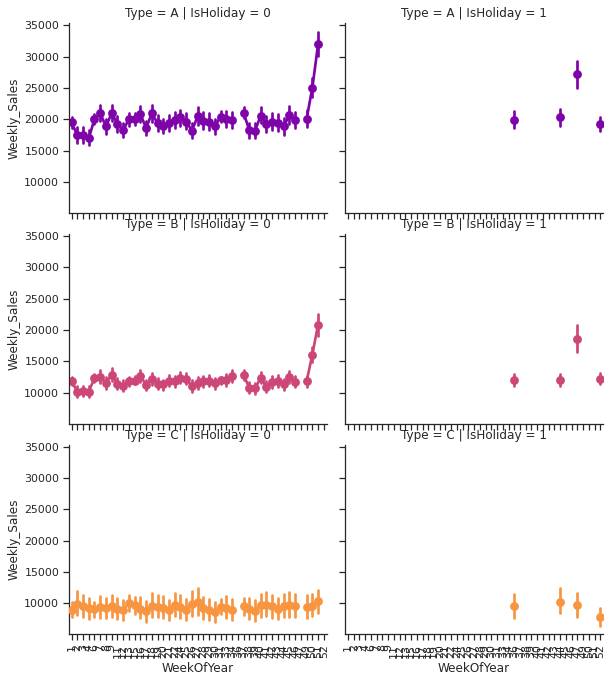

In [ ]:
# sales trends
sales_feat_2011 = sales_feat[sales_feat['Year'] == 2011]

g = sns.factorplot(data = sales_feat_2011, x = 'WeekOfYear', y = "Weekly_Sales", 
               col = 'IsHoliday', # per store type in cols
               palette = 'plasma',
               hue = 'Type',
               row = 'Type'
               ) 
g.fig.set_figwidth(8.27)
g.fig.set_figheight(9)
g.set_xticklabels(rotation=90)

Both store types A & B follow the same trend but at different scales. Already at this point, we can see that Sales escalate towards Christmas holidays. But we'll talk about seasonalities and trends later in the Time Series Analysis section. Sales of the store type C are relatively constant over the year. They seem less sensitive to markdowns.

Let's print a mean of `Weekly_Sales` for each store `Type` to see 
how the sales are distributed among the `Dept` :



In [ ]:
#Isolating sales of departments for each store type

sales_feat_A = sales_feat[(sales_feat.Type == 'A')]
sales_feat_B = sales_feat[(sales_feat.Type =='B')]
sales_feat_C = sales_feat[(sales_feat.Type == 'C')]
mean_sales_A = sales_feat_A.groupby('Dept')['Weekly_Sales'].mean().reset_index()
mean_sales_B = sales_feat_B.groupby('Dept')['Weekly_Sales'].mean().reset_index()
mean_sales_C = sales_feat_C.groupby('Dept')['Weekly_Sales'].mean().reset_index()

In [ ]:
sales_feat_A.head(2)

,Store,Dept,Weekly_Sales,IsHoliday,WeekOfYear,Year,Month,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
Date,,,,,,,,,,,,,,,,,,
2010-05-02,1,1,24924.50,0,17,2010,5,5.7,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
2010-12-02,1,1,46039.49,1,48,2010,12,3.6,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106,A,151315


In [ ]:
mean_sales_A

,Dept,Weekly_Sales
0,1,22956.887886
1,2,51994.674873
2,3,13881.033137
3,4,32973.814075
4,5,26803.448045
...,...,...
76,95,97094.026043
77,96,19900.943552
78,97,22093.807101
79,98,10979.816195


In [ ]:
#what are the store ids within each type?

print("Stores ids of type A:", sales_feat_A.Store.unique())
print("Stores ids of type B:", sales_feat_B.Store.unique())
print("Stores ids of type C:", sales_feat_C.Store.unique())

Stores ids of type A: [ 1  2  4  6  8 11 13 14 19 20 24 26 27 28 31 32 33 34 36 39 40 41]
Stores ids of type B: [ 3  5  7  9 10 12 15 16 17 18 21 22 23 25 29 35 45]
Stores ids of type C: [30 37 38 42 43 44]


<function matplotlib.pyplot.show>

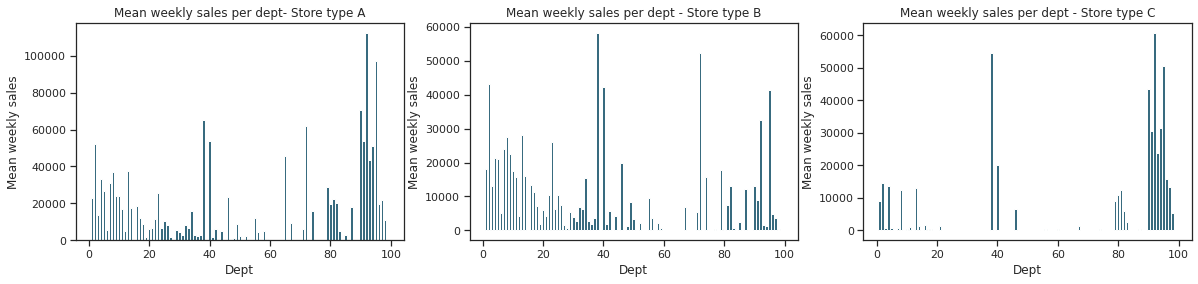

In [ ]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (20, 4))

plt.subplot(131)
plt.bar(mean_sales_A.Dept, mean_sales_A.Weekly_Sales, color = c)
plt.title("Mean weekly sales per dept- Store type A")
plt.xlabel("Dept")
plt.ylabel("Mean weekly sales")

plt.subplot(132)
plt.bar(mean_sales_B.Dept, mean_sales_B.Weekly_Sales, color = c)
plt.title("Mean weekly sales per dept - Store type B")
plt.xlabel("Dept")
plt.ylabel("Mean weekly sales")

plt.subplot(133)
plt.bar(mean_sales_C.Dept, mean_sales_C.Weekly_Sales, color = c)
plt.title("Mean weekly sales per dept - Store type C")
plt.xlabel("Dept")
plt.ylabel("Mean weekly sales")

plt.show

The offerings of the A & B stores are very numerous, and the average sales levels are very heterogeneous, ranging from low to high levels of sales. On the other hand, type C stores have fairly high sales levels although it offers a limited diversity of departments.

### Correlational Analysis

In [ ]:
#what are the departments selling the most.
max_mean_sales_A = mean_sales_A.Weekly_Sales.max()
max_mean_sales_B = mean_sales_B.Weekly_Sales.max()
max_mean_sales_C = mean_sales_C.Weekly_Sales.max()
print ("the department of A-type doing the max sales over the year is:", mean_sales_A.Dept[mean_sales_A.Weekly_Sales == max_mean_sales_A].iloc[0])
print ("the department of B-type doing the max sales over the year is:", mean_sales_B.Dept[mean_sales_B.Weekly_Sales == max_mean_sales_B].iloc[0])
print ("the department of C-type doing the max sales over the year is:", mean_sales_C.Dept[mean_sales_C.Weekly_Sales == max_mean_sales_C].iloc[0])

the department of A-type doing the max sales over the year is: 92
the department of B-type doing the max sales over the year is: 38
the department of C-type doing the max sales over the year is: 92


How some features and markdowns affect the sales.

In [ ]:
# Compute the correlation matrix and return ranking of features in absolute value of the known dept.
def corr_rank(_sales_feat, _dept):
      # exclude 'Store','Type','IsHoliday','Size','Dept','Year','Month' variables
      col_to_drop = ['Store', 'Type','IsHoliday','Size','Dept','Year','Month']
      corr_all=sales_feat[sales_feat['Dept'] == _dept].drop(col_to_drop, axis=1).corr()
      
      select_corr = corr_all[['Weekly_Sales']].drop('Weekly_Sales', axis = 0)
      select_corr = select_corr.reset_index().rename(columns={"index": "Feature"})
      select_corr["abs_corr_Weekly_Sales"] = np.abs(select_corr["Weekly_Sales"])
      _feat_rank = select_corr.sort_values(["abs_corr_Weekly_Sales"], ascending=False).reset_index(drop=True)
   
      return _feat_rank

In [ ]:
# set of the four most correlated features with Weekly_Sales for each department
majcorrfeat = pd.DataFrame(columns=['Dept','feat1','feat2', 'feat3', 'feat4'])
i=0
for dept in np.sort(sales_feat['Dept'].unique()):
  feat_rank=corr_rank(sales_feat, dept)
  mylist=feat_rank.loc[0:3,'Feature'].unique()
  majcorrfeat.loc[i, 'Dept']= dept
  majcorrfeat.loc[i, ['feat1', 'feat2', 'feat3', 'feat4']]= mylist
  i=i+1

In [ ]:
majcorrfeat.head(4)

,Dept,feat1,feat2,feat3,feat4
0,1,Temperature,CPI,Unemployment,MarkDown5
1,2,MarkDown1,MarkDown5,MarkDown4,CPI
2,3,MarkDown1,Temperature,MarkDown4,MarkDown5
3,4,MarkDown1,MarkDown5,MarkDown4,Unemployment


In [ ]:
#gather Dept ids that a MarkDown appears among the four most correlated factors 
featlist = ['feat1','feat2','feat3','feat4']
markdownlist = ['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']
subdptlist=[]
dptlist=[]
res = []

for feat in featlist:
  subdptlist=[]
  for mark in markdownlist:
    _subdpt_list = majcorrfeat[majcorrfeat[feat]==mark]['Dept'].unique()
    subdptlist.extend(_subdpt_list)
    _dptlist = list(dict.fromkeys(subdptlist))
  dptlist.extend(_dptlist)

#remove duplicates in the dptlist
[res.append(x) for x in dptlist if x not in res] 
res.sort()
print("Ids of the Dept whose sales are affected by markdowns:", res)


Ids of the Dept whose sales are affected by markdowns: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82, 83, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


We saw before similar sales curves in shape between stores type A et B. Let us see the wordcloud for stores `Type` A & B gathered, then C.

In [ ]:
array_A= sales_feat_A.Store.unique()
array_B= sales_feat_B.Store.unique()
array_AB = np.concatenate((array_A, array_B))
array_C= sales_feat_C.Store.unique()

In [ ]:
majcorrfeatAB=majcorrfeat[majcorrfeat['Dept'].isin(array_AB)]
majcorrfeatB=majcorrfeat[majcorrfeat['Dept'].isin(array_B)]
majcorrfeatC=majcorrfeat[majcorrfeat['Dept'].isin(array_C)]

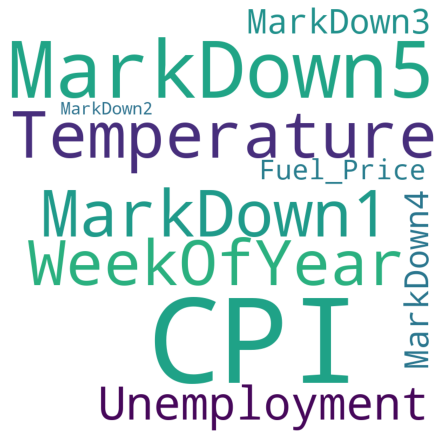

In [ ]:
# generate WordCloud, stores type A&B
  
comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the file 
for val in majcorrfeatAB.values: 
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split("'")
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

We have a strong correlation between the `Weekly_Sales` and the index of price `CPI` for the group of stores A & B. We can also observe a strong correlation between the sales and fact that `MarkDown5` and `MarkDown1` were running.



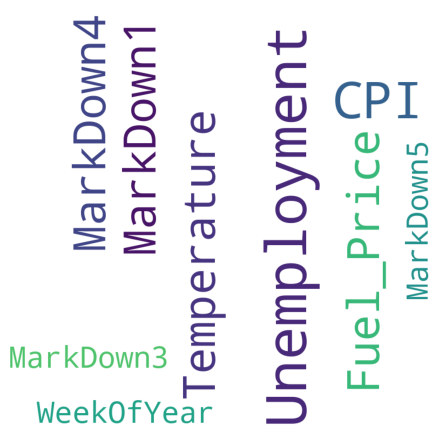

In [ ]:
# generate WordCloud, store type C
  
comment_words = '' 
stopwords = set(STOPWORDS) 

# iterate through the file 
for val in majcorrfeatC.values: 
    # typecaste each val to string 
    val = str(val)
    # split the value 
    tokens = val.split("'")
    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (6, 6), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

What a big difference for store type C! We have now a strong correlation between the `Weekly_Sales` and the the `Unemployment` rate for C-type stores. It seems that sales are sensitive to employment rate in the population. 
We can also now observe a strong correlation between the sales and fact that `MarkDown4` and `MarkDown1` were running.

### Conclusion of EDA

- The most selling store `Type` is A.

- Store types A and B are similar in the wide variety of their product offerings, which can be seen in an extensive list of departments. However, the best selling departments are different. 

- Constant `Weekly_Sales` amount over the year for store `Type` C indicates to the possible fact that people shop there essential things. The strong correlation between sales of `Type` C stores  and the `Unemployment` rate supports this assumption. That these stores are attended by a modest population that is careful to buy essential goods. 

- observation shared to all types of stores , we see sales per department highly correlated with the fact that some promotions are running, especially the `MarkDown5` and `MarkDown1` for store types A & B, and the `MarkDown4` and `MarkDown1` for store type C. Despite the presence of promotional periods throughout the year, we don't see their effect on total sales, except for store types A & B at Christmas where there is a peak. We would have to look in more detail at the department level to see the effects of the special offers.

We build a time series analysis on a chosen department and a  store type. The main advantage of this approach is its simplicity of presentation and overall account for different trends and seasonalities in the dataset. 

Along with an increasing or decreasing trend, series have some form of seasonality trends, i.e. variations specific to a particular time frame. In this section, we will analyse time series data: its trends, sesonalities and autocorrelation. We develop at the end forecasts using Prophet methodology. We will not develop a Seasonal ARIMA model (Autoregression Integrated Moving Average).

### Seasonality

We study one department (best seller department 92 as seen before) from store number 6, a store number randomly chosen that represents its group of store `Type` A.

It also makes sense to downsample the data from days to weeks using the `resample` method to see the present trends more clearly.

Let us first check that the particular departments comply the observations of EDA. We are plotting the seaborn heatmap.

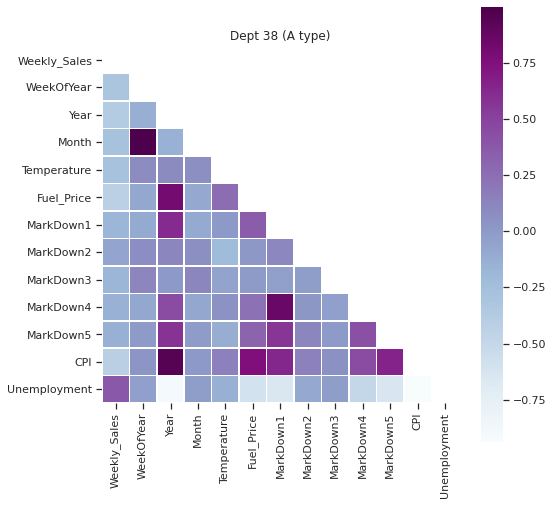

In [ ]:
# Compute the correlation matrix 

# exclude 'Store','Type','IsHoliday','Size' variables
corr_all_A_38 = sales_feat[sales_feat['Dept'] == 38]
corr_all_A_38 = corr_all_A_38[corr_all_A_38['Store'] == 6].drop(['Store','Type','IsHoliday','Size','Dept'], axis = 1).corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr_all_A_38, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
plt.rcParams["figure.figsize"] = (8,8)
f, axes = plt.subplots(1,1)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_all_A_38, mask = mask, square = True, linewidths = .5, ax = axes, cmap = "BuPu")
axes.set_title('Dept 38 (A type)')

plt.show()

Correlation with CPI can be seen.

Text(0, 0.5, 'Weekly Sales')

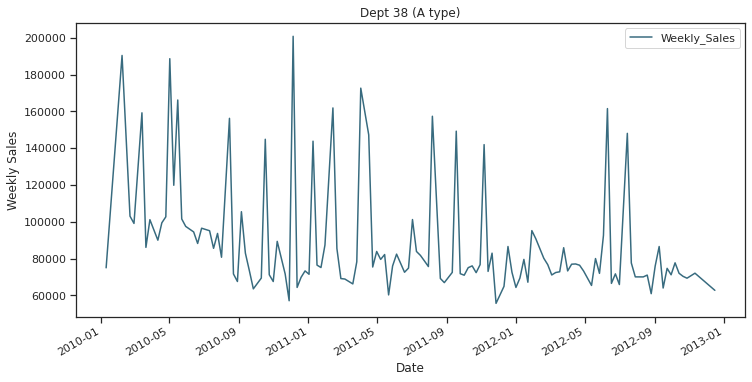

In [ ]:
# departments of different store types
sales_a38 = sales_feat[(sales_feat.Store == 6) & (sales_feat.Dept == 38)].loc[:, ['Weekly_Sales']]
sales_a38 = sales_a38.resample('W').sum()
sales_a38 = sales_a38[sales_a38.Weekly_Sales != 0]

f, ax1 = plt.subplots(1, figsize = (12, 6))

# departments of different store types
sales_a38.plot(color = c, ax = ax1)

ax1.set_title('Dept 38 (A type)');
ax1.set_ylabel('Weekly Sales')

Not obvious to catch seasonality, we can see that retail sales tend to peak for december.

### Yearly trend

The thing here is to check the presence of a trend in serie.

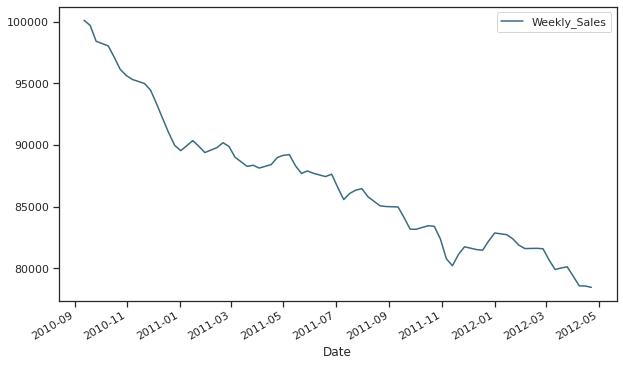

In [ ]:
f, ax1 = plt.subplots(1, figsize = (10, 6))

decomposition_a_38 = seasonal_decompose(sales_a38, model = 'additive', freq = 52)
decomposition_a_38.trend.plot(color = c, ax = ax1)

Overall sales seems to decrease.




### Autocorrelation

The next step in our time series analysis is to review Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. 

ACF is a measure of the correlation between the timeseries with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’tn’ with series at instant ‘t1-5’…’tn-5’ (t1-5 and tn being end points).

PACF, on the other hand, measures the correlation between the timeseries with a lagged version of itself but after eliminating the variations explained by the intervening comparisons. Eg. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. 

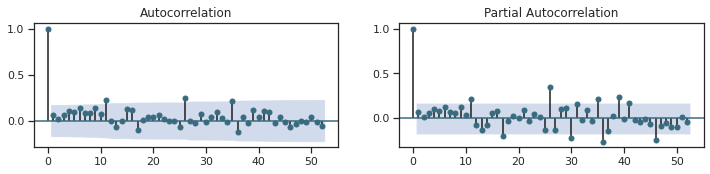

In [ ]:
# figure for subplots
plt.figure(figsize = (12, 16))

# acf and pacf for department 38 (A)
plt.subplot(621); plot_acf(sales_a38, lags = 52, ax = plt.gca(), color = c)
plt.subplot(622); plot_pacf(sales_a38, lags = 52, ax = plt.gca(), color = c)

plt.show()

Those plots are showing the correlation of the series with itself, lagged by x time units.We see the randomn of the time serie.

The Department show seasonalities at particular lags. There is a weekly trend with 
- positive spikes at each 26th, 39th observations
- negative spikes at each 30th, 36th, 47th observations. 

The holidays occuring at weeks W48 are Thanksgiving, Christmas is at W52.

## Time series analysis and forecasting with Prophet
#### Forecasting for the next 12 weeks for the depart.38 of an A-type store.

Prophet is a procedure developed by Facebook for forecasting time series. It is based on an additive model where non-linear trends are fit with yearly and weekly seasonality, plus holidays.

In [ ]:
# importing data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/projet retail/sales data-set.csv',
                   parse_dates = True, low_memory = False, index_col = 'Date')

# remove no sales
df = df[df['Weekly_Sales'] != 0]

# sales for the store number 6 (Store Type A), department number 38.
sales = df[(df.Store == 6) & (df.Dept == 38)].loc[:, ['Weekly_Sales']]
sales = sales.resample('W').sum()

In [ ]:
# a requirement from prophet is that every variables should have specific names
sales.reset_index(inplace= True)
sales = sales.rename(columns = {'Date': 'ds',
                                'Weekly_Sales': 'y'})
# remove introduced no sales values due to resampling
sales = sales[sales.y != 0]
sales.head()

,ds,y
0,2010-01-10,74960.52
4,2010-02-07,190354.92
6,2010-02-21,103021.56
7,2010-02-28,99082.28
9,2010-03-14,159181.77


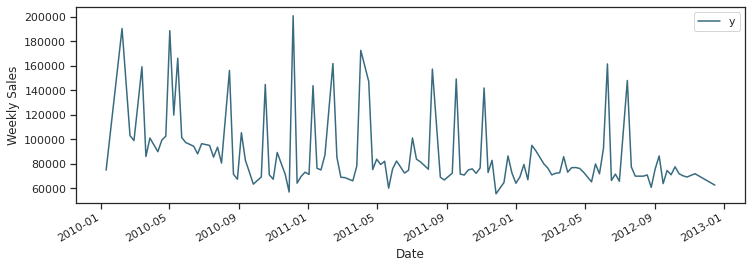

In [ ]:
# plot weekly sales
ax = sales.set_index('ds').plot(figsize = (12, 4), color = c)
ax.set_ylabel('Weekly Sales')
ax.set_xlabel('Date')
plt.show()

### Modeling Holidays

Prophet also allows to model for holidays.

In [ ]:
df.reset_index(inplace= True)

In [ ]:
# create holidays dataframe
val_holidays = df[df.IsHoliday == True].loc[:, 'Date'].values
holidays = pd.DataFrame({'holiday': 'IsHolidays',
                        'ds': pd.to_datetime(val_holidays)})
   
holidays.tail()

,holiday,ds
29653,IsHolidays,2011-09-09
29654,IsHolidays,2011-11-25
29655,IsHolidays,2011-12-30
29656,IsHolidays,2012-10-02
29657,IsHolidays,2012-07-09


In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, weekly_seasonality= False, daily_seasonality=False, seasonality_prior_scale=1.0,
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 12 weeks 
future_dates = my_model.make_future_dataframe(periods = 12, freq='W')

print("First week to forecast.")
future_dates.tail(7)

First week to forecast.


,ds
132,2013-01-27
133,2013-02-03
134,2013-02-10
135,2013-02-17
136,2013-02-24
137,2013-03-03
138,2013-03-10


In [ ]:
# predictions
forecast = my_model.predict(future_dates)

# preditions for last week
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)

,ds,yhat,yhat_lower,yhat_upper
132,2013-01-27,75318.093284,25255.322565,127658.743483
133,2013-02-03,94856.003145,45235.114018,147981.606997
134,2013-02-10,104071.927545,54487.261940,157036.333554
135,2013-02-17,92284.968214,32634.821628,144654.739505
136,2013-02-24,67155.278699,14811.349224,117087.595909
137,2013-03-03,48811.654841,-3102.213351,106542.441294
138,2013-03-10,50132.968700,-2877.298233,102901.153902


The forecast object here is a new dataframe that includes a column yhat with the forecast, as well as columns for components and uncertainty intervals.

In [ ]:
fc = forecast[['ds', 'yhat']].rename(columns = {'Date': 'ds', 'Forecast': 'yhat'})

The observed values of our time serie are plotted the black dots, the forecasted values (blue line) and the uncertainty intervals of our forecasts (the blue shaded regions).

In [ ]:
forecast.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,IsHolidays,IsHolidays_lower,IsHolidays_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,holidays_lower,holidays_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-10,107577.298009,45122.997025,147456.305547,107577.298009,107577.298009,0.0,0.0,0.0,-11507.393014,-11507.393014,-11507.393014,0.0,0.0,0.0,-11507.393014,-11507.393014,-11507.393014,0.0,0.0,0.0,96069.904995
1,2010-02-07,106615.060502,88064.037729,190756.492851,106615.060502,106615.060502,0.0,0.0,0.0,33139.400324,33139.400324,33139.400324,0.0,0.0,0.0,33139.400324,33139.400324,33139.400324,0.0,0.0,0.0,139754.460826
2,2010-02-21,106133.941748,60379.727097,172670.540619,106133.941748,106133.941748,0.0,0.0,0.0,10795.900983,10795.900983,10795.900983,0.0,0.0,0.0,10795.900983,10795.900983,10795.900983,0.0,0.0,0.0,116929.842732


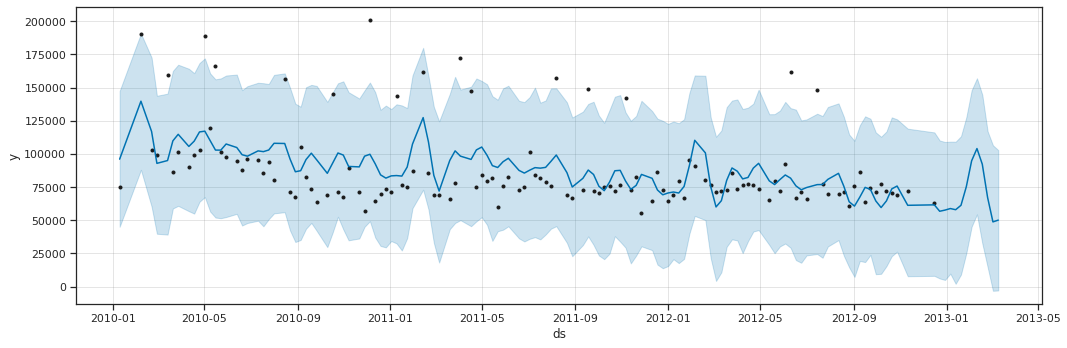

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = my_model.plot(forecast,
                 ax=ax)
plt.show()

Let us reveal how daily, weekly and yearly patterns of the time serie plus included holidays contribute to the overall forecasted values.

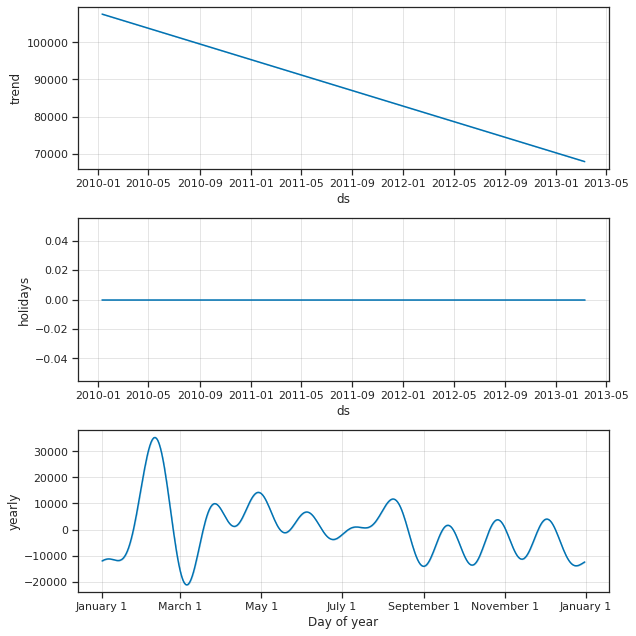

In [ ]:
my_model.plot_components(forecast);

The first plot shows that the monthly sales of the department has been linearly decreasing  over time. The third plot shows that the most buzy season occurs during february according to the model.


### Error metrics

In [ ]:
mean_squared_error(y_true=sales['y'],
                   y_pred=forecast.loc[:len(sales)-1,'yhat'])

726200777.3101498

In [ ]:
mean_absolute_error(y_true=sales['y'],
                   y_pred=forecast.loc[:len(sales)-1,'yhat'])

19043.998985615424

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=sales['y'],
                   y_pred=forecast.loc[:len(sales)-1,'yhat'])

19.785871909273393

RMSE error is 726200777 // 
MAE error is 19044.00 //
MAPE error is 19.8%